In [20]:
import pandas as pd
import numpy as np 
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from rdkit.Chem import Descriptors
from rdkit import Chem
from mordred import Descriptor,Calculator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,train_test_split,StratifiedKFold,KFold,cross_val_score
from sklearn.feature_selection import RFE,VarianceThreshold,RFECV,SelectFromModel
from sklearn import metrics
from rdkit import DataStructs


In [39]:
data = pd.read_csv("data/train_raw_data.csv",index_col=0)
test = pd.read_csv("data/external_test_raw_data.csv",index_col=0)



In [41]:
morgan_data_list = []
mackey_data_list = []
topo_data_list = []
morgan_test_list = []
mackey_test_list = []
topo_test_list = []
for i in range(len(data)):
    inchi = Chem.MolFromInchi(data["Inchi"][i])
    if inchi == None:
        print(i,":",data["Mol"][i],data["Toxicity"][i] )
        data.drop(index = i,inplace=True,axis=0)
    else:
        morgan_data_list.append(AllChem.GetMorganFingerprintAsBitVect(inchi, 2, nBits=2048))
        mackey_data_list.append(AllChem.GetMACCSKeysFingerprint(inchi))
        topo_data_list.append(AllChem.GetTopologicalTorsionFingerprint(inchi))
data.reset_index(inplace=True)
data.drop("index",axis = 1,inplace=True)



[01:02:47] WARNING: not removing hydrogen atom without neighbors
[01:02:47] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[01:02:47] ERROR: Explicit valence for atom # 0 Cl, 5, is greater than permitted



1322 : nan 0


[01:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match)

[01:02:51] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[01:02:51] ERROR: Explicit valence for atom # 0 Cl, 3, is greater than permitted



5624 : nan 0


[01:02:52] WARNING: not removing hydrogen atom without neighbors
[01:02:52] WARNING: not removing hydrogen atom without neighbors
[01:02:52] WARNING: not removing hydrogen atom without neighbors
[01:02:52] Explicit valence for atom # 0 Cl, 5, is greater than permitted
[01:02:52] ERROR: Explicit valence for atom # 0 Cl, 5, is greater than permitted



6454 : nan 0


[01:02:53] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[01:02:53] WARNING: not removing hydrogen atom without neighbors
[01:02:53] WARNING: not removing hydrogen atom without neighbors


In [42]:
morgan_test_list = []
mackey_test_list = []
topo_test_list = []
for i in range(len(test)):
    inchi = Chem.MolFromInchi(test["Inchi"][i])
    if inchi == None:
        print(i,":",test["Mol"][i],test["Toxicity"][i] )
        test.drop(index = i,inplace=True,axis=0)
    else:
        morgan_test_list.append(AllChem.GetMorganFingerprintAsBitVect(inchi, 2, nBits=2048))
        mackey_test_list.append(AllChem.GetMACCSKeysFingerprint(inchi))
        topo_test_list.append(AllChem.GetTopologicalTorsionFingerprint(inchi))
test.reset_index(inplace=True)
test.drop("index",axis = 1,inplace=True)


In [46]:
#train
similarity_matrix = np.zeros((len(morgan_data_list), len(morgan_data_list)))
similarity_matrix2 = np.zeros((len(mackey_data_list), len(mackey_data_list)))
similarity_matrix3 = np.zeros((len(topo_data_list), len(topo_data_list)))
for i in range(len(morgan_data_list)):
    for j in range(i, len(morgan_data_list)):
        similarity_matrix[i][j] = DataStructs.TanimotoSimilarity(morgan_data_list[i], morgan_data_list[j])
        similarity_matrix[j][i] = similarity_matrix[i][j]
for i in range(len(mackey_data_list)):
    for j in range(i, len(mackey_data_list)):
        similarity_matrix2[i][j] = DataStructs.TanimotoSimilarity(mackey_data_list[i], mackey_data_list[j])
        similarity_matrix2[j][i] = similarity_matrix2[i][j]
for i in range(len(topo_data_list)):
    for j in range(i, len(topo_data_list)):
        similarity_matrix3[i][j] = DataStructs.TanimotoSimilarity(topo_data_list[i], topo_data_list[j])
        similarity_matrix3[j][i] = similarity_matrix3[i][j]
#test
similarity_matrix4 = np.zeros((len(morgan_test_list), len(morgan_test_list)))
similarity_matrix5 = np.zeros((len(mackey_test_list), len(mackey_test_list)))
similarity_matrix6 = np.zeros((len(topo_test_list), len(topo_test_list)))
for i in range(len(morgan_test_list)):
    for j in range(i, len(morgan_test_list)):
        similarity_matrix4[i][j] = DataStructs.TanimotoSimilarity(morgan_test_list[i], morgan_test_list[j])
        similarity_matrix4[j][i] = similarity_matrix4[i][j]
for i in range(len(mackey_test_list)):
    for j in range(i, len(mackey_test_list)):
        similarity_matrix5[i][j] = DataStructs.TanimotoSimilarity(mackey_test_list[i], mackey_test_list[j])
        similarity_matrix5[j][i] = similarity_matrix5[i][j]
for i in range(len(topo_test_list)):
    for j in range(i, len(topo_test_list)):
        similarity_matrix6[i][j] = DataStructs.TanimotoSimilarity(topo_test_list[i], topo_test_list[j])
        similarity_matrix6[j][i] = similarity_matrix6[i][j]

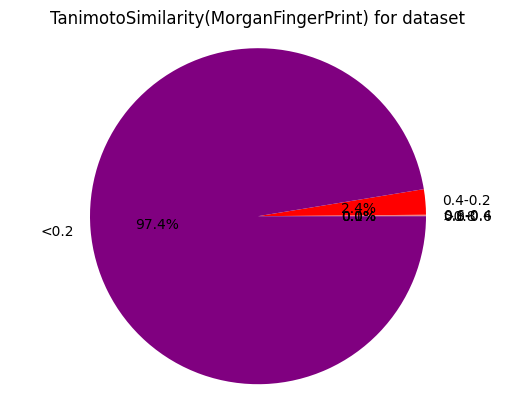

Average TanimotoSimilarity(MorganFingerPrint) for dataset : 0.08145000356238127


In [47]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=range(len(morgan_data_list)), columns=range(len(morgan_data_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(MorganFingerPrint) for dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(MorganFingerPrint) for dataset : {}".format(avg/num))

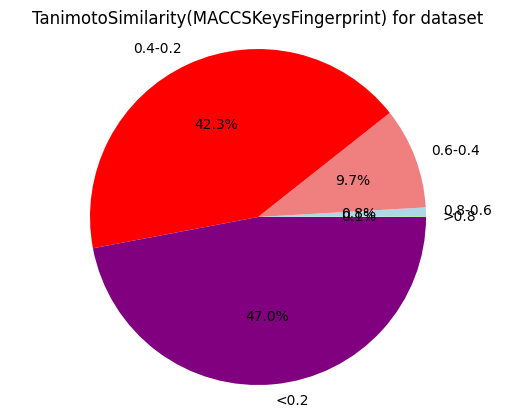

Average TanimotoSimilarity(MACCSKeysFingerprint) for dataset : 0.22785841606722332


In [48]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix2, index=range(len(mackey_data_list)), columns=range(len(mackey_data_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(MACCSKeysFingerprint) for dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(MACCSKeysFingerprint) for dataset : {}".format(avg/num))

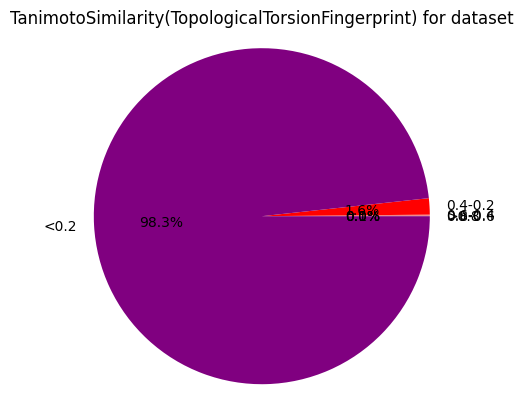

Average TanimotoSimilarity(TopologicalTorsionFingerprint) for dataset : 0.031148834224749143


In [49]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix3, index=range(len(topo_data_list)), columns=range(len(topo_data_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(TopologicalTorsionFingerprint) for dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(TopologicalTorsionFingerprint) for dataset : {}".format(avg/num))

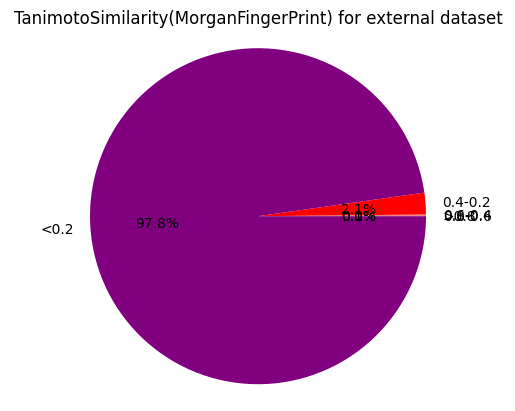

Average TanimotoSimilarity(MorganFingerPrint) for external dataset : 0.07646495565655603


In [50]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix4, index=range(len(morgan_test_list)), columns=range(len(morgan_test_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(MorganFingerPrint) for external dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(MorganFingerPrint) for external dataset : {}".format(avg/num))

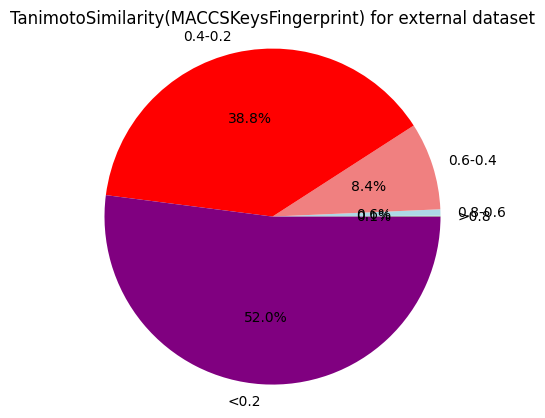

Average TanimotoSimilarity(MACCSKeysFingerprint) for external dataset : 0.21392243364219515


In [51]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix5, index=range(len(mackey_test_list)), columns=range(len(mackey_test_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(MACCSKeysFingerprint) for external dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(MACCSKeysFingerprint) for external dataset : {}".format(avg/num))

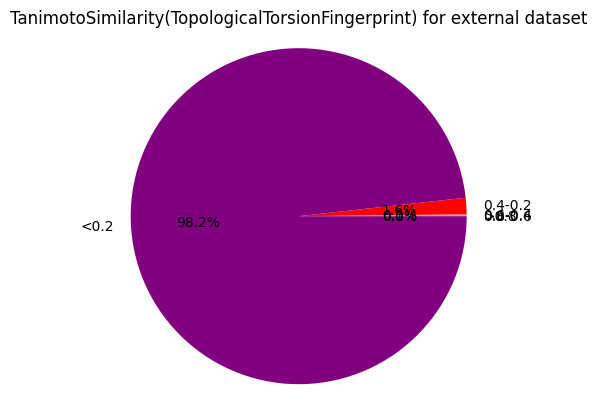

Average TanimotoSimilarity(TopologicalTorsionFingerprint) for external dataset : 0.029692991738580334


In [52]:
# 轉換相似性矩陣為DataFrame
similarity_df = pd.DataFrame(similarity_matrix6, index=range(len(topo_test_list)), columns=range(len(topo_test_list)))

# 尋找相似度大於0.8的化合物對
# 將谷本係數分成不同範圍
range1 = 0  # 谷本係數範圍1的數量
range2 = 0  # 谷本係數範圍2的數量
range3 = 0  # 谷本係數範圍3的數量
range4 = 0  # 谷本係數範圍4的數量
range5 = 0  # 谷本係數範圍5的數量
avg = 0
num = 0
similar_compounds = []
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        num = num + 1
        avg = avg + similarity_df.iloc[i, j]
        if similarity_df.iloc[i, j] > 0.8:
            range1 += 1
        elif similarity_df.iloc[i, j] > 0.6:
            range2 += 1
        elif similarity_df.iloc[i, j] > 0.4:
            range3 += 1
        elif similarity_df.iloc[i, j] > 0.2:
            range4 += 1
        else:
            range5 += 1

# 製作圓餅圖
labels = ['>0.8', '0.8-0.6', '0.6-0.4', '0.4-0.2','<0.2']  # 標籤
sizes = [range1, range2, range3,range4,range5]  # 比例
colors = ['lightgreen', 'lightblue', 'lightcoral','red','purple']  # 顏色
explode = (0.1, 0, 0)  # 突出顯示第一個區塊

plt.pie(sizes,  labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')  # 使圓餅圖呈現為圓形
plt.title('TanimotoSimilarity(TopologicalTorsionFingerprint) for external dataset')  # 圖標題

plt.show()  # 顯示圓餅圖
print("Average TanimotoSimilarity(TopologicalTorsionFingerprint) for external dataset : {}".format(avg/num))